In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 3.3 MB 4.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
# from transformers import AutoTokenizer
# from transformers.data.data_collator import DataCollatorForWholeWordMask, DataCollatorForLanguageModeling
# from transformers import LineByLineTextDataset
from nltk import sent_tokenize
from tokenizers import Tokenizer
import torch

In [4]:
df = pd.read_csv(
    'data/jd.csv', 
    nrows=1000
)

In [5]:
df.FullDescription.iloc[6]

'A globally renowned engineering and training company in the Oil Develop and manage both internal and external inspection plans and plan remedial and preventative maintenance work Implement, apply and update pipeline databases and spreadsheets and assist operators with projects, including project management, assurance support and procedure reviews Handle consulting, problem solving, risk assessments and presentations Be responsible for technical representation offshore Prepare proposals and tenders for clients and write reports and specifications. You will offer analysis using various types of software such as MathCAD, ABAQUS, Olga or Orcaflex. You will also present the company s technical courses and handle project management and sales and customer relationship management. For this role, you must have a minimum of 10 years experience in subsea engineering, pipelines design or construction. Background in controls, corrosion, decommissioning or structures would be an advantage. A degree

In [6]:
df.shape

(1000, 12)

In [7]:
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', max_length=1024)
tokenizer = Tokenizer.from_file("data/jd_tokenizer_wordpiece.json")
tokenizer.enable_padding()
# tokenizer.add_special_tokens(["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
encoded = tokenizer.encode_batch(['this is a large string with a lot of words', 'a larger sent'])

In [10]:
encoded[0].tokens

['this', 'is', 'a', 'large', 'string', 'with', 'a', 'lot', 'of', 'words']

In [11]:
import random
class DataCollatorForLanguageModeling:
    def __init__(self, tokenizer, mlm_probability=0.15):
        self.tokenizer = tokenizer
        self.mlm_probability = mlm_probability
        self.special_token_ids = []
        self.vocab_size = tokenizer.get_vocab_size()
        for i in range(len(tokenizer.get_vocab())):
            tok = tokenizer.id_to_token(i)
            if tok[0] == '[' and tok[-1] == ']':
                self.special_token_ids.append(i)
            else:
                break
        
    def __call__(self, batch):
        shape = (len(batch), len(batch[0]))
        labels = torch.full(shape, -100)
        mask = torch.full(shape, True)
#         input_ids
        for i in range(len(batch)):
            for j in range(len(batch[0])):
                tok = batch[i][j]
                if tok == 0:
                    break
                else:
                    r1 = random.random()
                    r2 = random.random()
                    if r1 < self.mlm_probability and tok not in self.special_token_ids:
                        if r2 < 0.8:
                            replacement = self.tokenizer.token_to_id('[MASK]')
                        elif r2 < 0.9:
                            replacement = random.randint(100, self.vocab_size-1)
                        else:
                            replacement = tok
                        
                        batch[i][j] = replacement
                        labels[i][j] = tok
                    else:
                        mask[i][j] = False
        
        return {
            'input_ids': torch.tensor(batch),
            'mask': mask,
            'labels': labels
        }

In [12]:
dc = DataCollatorForLanguageModeling(tokenizer, mlm_probability=0.2)

In [13]:
def get_mlm_batch(sentences):
    sentences = [f'[CLS] {s} [SEP]' for s in sentences]
    toks = tokenizer.encode_batch(
        sentences,
        add_special_tokens=True
    )
    toks = [t.ids for t in toks]
    
    return dc(toks)

In [15]:
bat = get_mlm_batch(['this is a sent', 'this is another sent but longer'])
bat

{'input_ids': tensor([[   2,  220,  200,   37, 4357,    3,    0,    0],
         [   2,  220,  200, 3966, 4357,  768, 4311,    3]]),
 'mask': tensor([[False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False, False]]),
 'labels': tensor([[-100, -100, -100, -100, -100, -100, -100, -100],
         [-100, -100, -100, -100, -100, -100, -100, -100]])}

In [38]:
x = bat['input_ids']

In [39]:
x.size()

torch.Size([2, 8])

In [17]:
mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

In [48]:
(x > 0).unsqueeze(1).repeat(1, x.size(1), 1)

tensor([[[ True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True, False, False]],

        [[ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  

In [29]:
x.shape

torch.Size([3])

In [25]:
tokenizer.id_to_token(200)

'is'

In [26]:
def line_by_line_generator(jds, batch_size=32, max_length=128):
    examples = []
    ex = ''
    current_token_count = 0
    while True:
        for jd in jds:
            if len(ex) > 0:
                ex += ' [SEP] '
            sents = sent_tokenize(jd)
            for sent in sents:
                sent_len = len(sent.split())
                if current_token_count + sent_len >= max_length:
                    examples.append(ex)
                    ex = ''
                    current_token_count = 0
                    if len(examples) == batch_size:
                        batch = get_mlm_batch(examples)
                        yield batch
                        examples = []

                ex += sent
                current_token_count += sent_len

In [27]:
for index, batch in enumerate(line_by_line_generator(df.FullDescription, batch_size=4)):
    if index > 5:
        break
#     print(len(batch))
#     print(batch)

In [38]:
batch['input_ids']

tensor([[    2,   662, 14824,  2937,   569,    27,    12,    12,  7447,    12,
             4,    12,    12,    12,    12, 13175,   623,   210,   513,    11,
           711,     4,  2476,    27,     4,    14,  7576,     4,  1257,  1285,
             3,    37,   543,  3002,  1673,  2476,   160,   153,  5353,   850,
             4,     4,  1149,   212,     4,   278,   985,   278,     4,    37,
          1149,   212,  2612,   451,   200,  1848,   930,   330,   186,   322,
             4,     4,   157,    37,   400,   785,   200,   456,   387,   491,
           153,     4,   168,  3945,   320,   202,  1828,  2036,  1673,    15,
           153,  1673,  7000,    12,    12,    12,    12,  4767,   320,  4261,
           186,     4,  1015,  4668,   152,   496,   157,     4,    12,    12,
             4,  4767,   160,   153,  4938,   183,     4,    37,     4,     4,
          4668,    14,   196,  1149,     4,  2612,   176,   199,   193,  1588,
           157,  1270,    37,  3902,  3455,     4,  

In [37]:
decoded = tokenizer.decode_batch(batch['input_ids'].numpy())
decoded = [d.replace(' ##', '') for d in decoded]
decoded

['senior fatigue aerospace salary : * * oct * * * * *etric dep on exp ) benefits located : , avon south west a well respected restaurant located in the derby area chef de role available role a chef de partie who is passionate about working with all to a high standard is required resp join the of chefs at an award winning restaurant . the restaurant serves * * * * covers at lunch with set menu and up to * * covers in the evening for a menu , as chef partie you will be expected to run a section once trained keeping your work space and tidy at all times .',
 ": all chef de parties applying for this role should have fresh food experience at this level with paraleg ability to manage a busy . role can offer the right candidate excellent opportunities to within the team . benefits include : uniform provided meals on duty excellent tips – tack monthly excellent to progress if you are interested in this position or would like information on the other positions we recruiting for or any temporary

In [40]:
import torch
from torch import nn, optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
class RNN_MLM(nn.Module):
    def __init__(self, tokenizer, embedding_dim=512, model_dim=784):
        super().__init__()
        self.num_tokens = len(tokenizer.get_vocab())
        self.token_embedding = nn.Embedding(self.num_tokens, embedding_dim)
        self.up_scale = nn.Linear(embedding_dim, model_dim)
        self.encoders = nn.ModuleList([nn.LSTM(model_dim, int(model_dim/2), num_layers=1, batch_first=True, bidirectional=True) for _ in range(6)])
        self.output = nn.Linear(model_dim, embedding_dim)
        
    
        
    def forward(self, x):
        # shape of x => (B, T)
        emb = self.token_embedding(x) # shape => (B, T, 512)
        emb = self.up_scale(emb) # shape => (B, T, 786)
        emb = F.relu(emb)
        
        for index, lstm in enumerate(self.encoders):
            out, _ = lstm(emb)
            if index > 0:
                emb = out + emb
            else:
                emb = out

        emb = F.relu(emb)    # shape = (B, T, 786) 
        emb = self.output(emb) # shape = (B, T, 512)
        
 
        output = torch.matmul(emb, self.token_embedding.weight.T) # (B, T, vocab_size)
        
        return output

In [81]:
# rnn_mlm_model = RNN_MLM(tokenizer)
rnn_mlm_model = load_model('models/rnn_6_786_bi_wordpiece.pt')
rnn_mlm_model.to(device)

RNN_MLM(
  (token_embedding): Embedding(36000, 512)
  (up_scale): Linear(in_features=512, out_features=784, bias=True)
  (encoders): ModuleList(
    (0): LSTM(784, 392, batch_first=True, bidirectional=True)
    (1): LSTM(784, 392, batch_first=True, bidirectional=True)
    (2): LSTM(784, 392, batch_first=True, bidirectional=True)
    (3): LSTM(784, 392, batch_first=True, bidirectional=True)
    (4): LSTM(784, 392, batch_first=True, bidirectional=True)
    (5): LSTM(784, 392, batch_first=True, bidirectional=True)
  )
  (output): Linear(in_features=784, out_features=512, bias=True)
)

In [82]:
optimizer = optim.AdamW(rnn_mlm_model.parameters())

In [83]:
running_loss = 0.0
losses = []

In [84]:
rnn_mlm_model

RNN_MLM(
  (token_embedding): Embedding(36000, 512)
  (up_scale): Linear(in_features=512, out_features=784, bias=True)
  (encoders): ModuleList(
    (0): LSTM(784, 392, batch_first=True, bidirectional=True)
    (1): LSTM(784, 392, batch_first=True, bidirectional=True)
    (2): LSTM(784, 392, batch_first=True, bidirectional=True)
    (3): LSTM(784, 392, batch_first=True, bidirectional=True)
    (4): LSTM(784, 392, batch_first=True, bidirectional=True)
    (5): LSTM(784, 392, batch_first=True, bidirectional=True)
  )
  (output): Linear(in_features=784, out_features=512, bias=True)
)

In [85]:
tokenizer.encode("thiss").ids

[220, 118]

In [86]:
tokenizer.decode([220, 118])

'this ##s'

In [87]:
accumulation_steps = 8
rnn_mlm_model.train()
for index, batch in enumerate(line_by_line_generator(df.FullDescription.sample(frac=1.0), batch_size=8, max_length=128)):
    if index > 50000:
        break

    inp = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    
    output = rnn_mlm_model(inp)
    output_shape = output.shape
    
    # shape = (B, T, vocab_size)
    loss = F.cross_entropy(output.view(-1, output_shape[-1]), labels.view(-1))
    lit = loss.item()
    losses.append(lit)
    running_loss = 0.9 * running_loss + 0.1 * lit
    if index % 10 == 0:
        print(f'Running loss at {index} is {running_loss}')
    
    loss = loss / accumulation_steps
    loss.backward()
    if (index+1) % accumulation_steps == 0:  
        optimizer.step()
        optimizer.zero_grad()

Running loss at 0 is 0.2883319854736328
Running loss at 10 is 2.047886356065185
Running loss at 20 is 2.7362726179513803
Running loss at 30 is 2.876843284275882
Running loss at 40 is 2.9761466023428693
Running loss at 50 is 3.0821742050928123
Running loss at 60 is 3.2654095083522514
Running loss at 70 is 3.1683940440989407
Running loss at 80 is 3.1135590623528007
Running loss at 90 is 3.0351139654864805
Running loss at 100 is 2.989491740134164
Running loss at 110 is 2.9485207348814284


KeyboardInterrupt: 

In [92]:
def save_model(model, PATH):
    torch.save(model.state_dict(), PATH)

In [77]:
def load_model(PATH):
    model = RNN_MLM(tokenizer)
    model.load_state_dict(torch.load(PATH, map_location=device))
    model.eval()
    return model

In [78]:
# save_model(rnn_mlm_model, 'models/rnn_6_786_bi_wordpiece.pt')

In [74]:
# rnn_mlm_model = load_model('models/rnn_4_bi_wordpiece.pt')

In [79]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly import express as px

<AxesSubplot:>

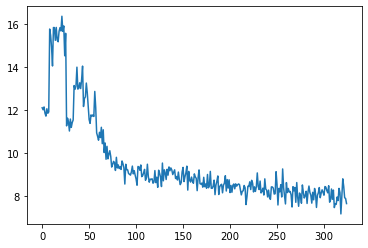

In [80]:
ls = pd.Series(losses)
ls.plot()

In [97]:
rnn_mlm_model.eval()

RNN_MLM(
  (token_embedding): Embedding(36000, 512)
  (up_scale): Linear(in_features=512, out_features=784, bias=True)
  (encoders): ModuleList(
    (0): LSTM(784, 392, batch_first=True, bidirectional=True)
    (1): LSTM(784, 392, batch_first=True, bidirectional=True)
    (2): LSTM(784, 392, batch_first=True, bidirectional=True)
    (3): LSTM(784, 392, batch_first=True, bidirectional=True)
    (4): LSTM(784, 392, batch_first=True, bidirectional=True)
    (5): LSTM(784, 392, batch_first=True, bidirectional=True)
  )
  (output): Linear(in_features=784, out_features=512, bias=True)
)

In [88]:
df[df.Title.notnull() & df.Title.str.contains('Software Developer')].iloc[0]['FullDescription']

'C Developer Belfast Salary up to ****k pa Our client, a leading edge Software Development Centre in Belfast requires C Developers to deliver key software products directly for their clients and for their business teams using the latest Microsoft technologies (.NET C, ASP.NET and SQL Server). Key Accountabilities • Design and develop cuttingedge software solutions, developed in C .Net with SQL as the back end data store. • Ensure all deliverables for projects are completed on time, to budget and within quality standards. • Assist the Project Manager in production of estimates for development activity. • Work with the Business and Data Analysts to drive the requirements forward. • Provide support and consultancy across all test phases of the project. • Participation in planning of software releases, their execution and postrelease activities. • Assist with maintenance and production support. • Support colleagues through advice and technical assistance. Key Technical Skills • A degree in

In [89]:
para = """C Developer Belfast Salary up to ****k pa Our client, a leading edge [MASK] Development Centre in Belfast requires C [MASK] to deliver key software products directly for their clients and for their [MASK] teams using the latest Microsoft [MASK] (.NET C, ASP.NET and SQL Server). Key [MASK] • Design and develop cuttingedge [MASK] solutions, developed in C .Net with SQL as the back [MASK] data store. • Ensure all deliverables for [MASK] are completed on time, to [MASK] and within quality standards. • Assist the Project [MASK] in production of estimates for development activity. • Work with the Business and Data [MASK] to drive the requirements forward. • Provide support and consultancy across all test phases of the project. • Participation in planning of software releases, their execution and postrelease activities. • Assist with maintenance and production support. • Support colleagues through advice and technical assistance. Key Technical Skills • A degree in IT or related subject and at least 2 years recent relevant experience in .NET software development within a commercial environment. • Technically excellent in C, ASP.NET, MVC, web development using Visual Studio, also strong working knowledge of SQL Server and TFS. • Experience of full software lifecycle and different methodologies. • Working knowledge of design patterns and practices. • Excellent time management skills and the proven ability and drive to meet deadlines. • Excellent teamworking skills, ability to work independently, show ownership and commitment to the success of the team. • Proven problem solving skills, analytical mind and a keen eye for detail. Hours of work: Core hours are 8am to 6pm Monday to Friday and you will be required to work 37.5 hours per week, timings will be agreed with your manager. Recruitment Direct is acting as a recruitment agency"""
# para = para.replace('\n', ' ')
toks = tokenizer.encode(f'[CLS] {para} [SEP]')
toks = torch.tensor([toks.ids]).to(device)

In [90]:
output = rnn_mlm_model(toks)
output = output.argmax(dim=-1)[0].cpu()

In [91]:
tokenizer.decode(output.numpy()).replace(' ##', '')

'. c developer ) salary up to * * * * k pa our client , a leading edge and development centre in belfast requires c developers to deliver key software products directly for their clients and for their development teams using the latest microsoft technologies ( . net c , asp . net and sql server ) . key responsibilities • design and develop cuttingedge software solutions , developed in c . net with sql as the back of data infrastructure . • ensure all deliverables for projects are completed on time , to budget and within quality standards . • assist the project manager in production of estimates for development activity . • work with the business and data managers to drive the requirements forward . • provide support and consultancy across all test phases of the project . • participation in planning of software releases , their implementation and post development activities . • assist with maintenance and production support . • support colleagues through advice and technical assistance 

In [51]:
# df[df.FullDescription.str.contains('data science')]

In [57]:
df.FullDescription[5500]

'Location  Leeds. My client, an established and growing IT company are currently recruiting for a Telemarketing Executive. This is an exciting new business sales opportunity to join a forward thinking organisation that continues to go from strength to strength. The Telemarketing Executive role offers an excellent platform for progression to Senior Account Manager. Role Profile: The Telemarketer function is a key position to feed the growth objectives of the organisation. The intention of this position is to drive new clients to a Workshop and/or contact new clients on a range of specific products and service offerings on a project by project basis. The position is a training ground to further graduate onto junior account manager role after approximately ****2 months. It is expected that you will be capable of using the phone and email to convey value of the workshop or project with a qualified decision maker. Key Responsibilities: Your main targets will include: Ability to make **** ou

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [72]:
import gc
# del rnn_mlm_model
# del optimizer
gc.collect()

126

In [ ]:
batch['input_ids'].shape

In [ ]:
output.view(-1, output.shape[-1]).shape

In [ ]:
labels.shape

In [ ]:
out = rnn_mlm_model(batch['input_ids'])

In [ ]:
running_loss = 0.0